In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

In [2]:
paradas = gpd.read_file('paradasBuses.geojson')
comunas_urbanas = gpd.read_file('r13.geojson')
proyecciones = pd.read_csv('comunas_proyeccion_region_2024.csv')

In [3]:
comuna_codes = {
    '13101': 'Santiago', '13102': 'Cerrillos', '13103': 'Cerro Navia', '13104': 'Conchali',
    '13105': 'El Bosque', '13106': 'Estacion Central', '13107': 'Huechuraba', 
    '13108': 'Independencia', '13109': 'La Cisterna', '13110': 'La Florida',
    '13111': 'La Granja', '13112': 'La Pintana', '13113': 'La Reina', 
    '13114': 'Las Condes', '13115': 'Lo Barnechea', '13116': 'Lo Espejo',
    '13117': 'Lo Prado', '13118': 'Macul', '13119': 'Maipu', '13120': 'Nunoa',
    '13121': 'Pedro Aguirre Cerda', '13122': 'Penalolen', '13123': 'Providencia',
    '13124': 'Pudahuel', '13125': 'Quilicura', '13126': 'Quinta Normal',
    '13127': 'Recoleta', '13128': 'Renca', '13129': 'San Joaquin', 
    '13130': 'San Miguel', '13131': 'San Ramon', '13132': 'Vitacura',
    '13201': 'Puente Alto'
}

In [4]:
comunas_urbanas = comunas_urbanas[comunas_urbanas['codigo_comuna'].astype(str).isin(comuna_codes.keys())]

comunas_urbanas['nombre_comuna'] = comunas_urbanas['codigo_comuna'].map(comuna_codes)

In [ ]:
paradas = paradas.to_crs(comunas_urbanas.crs)

paradas_con_comunas = gpd.sjoin(paradas, comunas_urbanas[['geometry', 'nombre_comuna']], how='inner', op='within')

In [6]:
comunas_urbanas = comunas_urbanas.dissolve(by='codigo_comuna', as_index=False)

In [7]:
comunas_urbanas = comunas_urbanas.to_crs("EPSG:32719")
comunas_urbanas['area_urbanizada'] = comunas_urbanas.geometry.area / 1_000_000  

In [8]:
print(comunas_urbanas.crs)
print(comunas_urbanas[['codigo_comuna', 'nombre_comuna', 'area_urbanizada']].tail())

EPSG:32719
   codigo_comuna nombre_comuna  area_urbanizada
28         13129   San Joaquin         9.940558
29         13130    San Miguel         9.611842
30         13131     San Ramon         6.278177
31         13132      Vitacura        28.419549
32         13201   Puente Alto        75.861687


In [9]:
paradas_por_comuna = paradas_con_comunas.groupby('nombre_comuna').size().reset_index(name='num_paradas')

datos_comunas = comunas_urbanas.merge(paradas_por_comuna, on='nombre_comuna', how='left')

datos_comunas['num_paradas'] = datos_comunas['num_paradas'].fillna(0)

In [10]:
print(datos_comunas[['nombre_comuna', 'area_urbanizada', 'num_paradas']].tail())

   nombre_comuna  area_urbanizada  num_paradas
28   San Joaquin         9.940558          236
29    San Miguel         9.611842          183
30     San Ramon         6.278177          191
31      Vitacura        28.419549          188
32   Puente Alto        75.861687          868


In [11]:
proyecciones['Comuna'] = proyecciones['Comuna'].str.upper()
datos_comunas['nombre_comuna_upper'] = datos_comunas['nombre_comuna'].str.upper()

proyecciones_filtradas = proyecciones[['Comuna', 'Proyeccion_Personas_2024']][proyecciones['Comuna'].isin(datos_comunas['nombre_comuna_upper'])]

datos_comunas = datos_comunas.merge(proyecciones_filtradas, left_on='nombre_comuna_upper', right_on='Comuna', how='left')

datos_comunas = datos_comunas.drop(columns=['nombre_comuna_upper', 'Comuna'])

In [12]:
datos_comunas['IPH'] = datos_comunas['num_paradas'] / datos_comunas['Proyeccion_Personas_2024']
datos_comunas['IPA'] = datos_comunas['num_paradas'] / datos_comunas['area_urbanizada']

datos_comunas['IPH_norm'] = (datos_comunas['IPH'] - datos_comunas['IPH'].min()) / (datos_comunas['IPH'].max() - datos_comunas['IPH'].min())
datos_comunas['IPA_norm'] = (datos_comunas['IPA'] - datos_comunas['IPA'].min()) / (datos_comunas['IPA'].max() - datos_comunas['IPA'].min())

datos_comunas['IC'] = (datos_comunas['IPH_norm'] + datos_comunas['IPA_norm']) / 2

In [13]:
print(datos_comunas[['nombre_comuna', 'IPH', 'IPA', 'IPH_norm', 'IPA_norm', 'IC']].tail())

   nombre_comuna       IPH        IPA  IPH_norm  IPA_norm        IC
28   San Joaquin  0.002289  23.741122  0.649641  0.745935  0.697788
29    San Miguel  0.001258  19.039014  0.121251  0.567143  0.344197
30     San Ramon  0.002282  30.422842  0.646284  1.000000  0.823142
31      Vitacura  0.001937   6.615165  0.469378  0.094740  0.282059
32   Puente Alto  0.001300  11.441876  0.142380  0.278270  0.210325


In [14]:
datos_comunas.head()

,codigo_comuna,geometry,geocodigo,codigo_provincia,codigo_region,nombre_comuna,area_urbanizada,num_paradas,Proyeccion_Personas_2024,IPH,IPA,IPH_norm,IPA_norm,IC
0,13101,"POLYGON ((347435.189 6294685.496, 346861.827 6...",13101091001,131,13,Santiago,23.134749,600,544388,0.001102,25.935012,0.041122,0.829355,0.435239
1,13102,"POLYGON ((341557.781 6288493.987, 339676.855 6...",13102041003,131,13,Cerrillos,16.776764,268,90182,0.002972,15.974475,1.000000,0.450617,0.725309
2,13103,"POLYGON ((339891.405 6298725.495, 339764.591 6...",13103081001,131,13,Cerro Navia,11.101259,239,139632,0.001712,21.529089,0.353713,0.661825,0.507769
3,13104,"POLYGON ((344490.996 6303150.503, 343862.317 6...",13104081001,131,13,Conchali,11.105349,304,136674,0.002224,27.374196,0.616627,0.884079,0.750353
4,13105,"POLYGON ((345773.222 6283152.009, 345721.244 6...",13105021001,131,13,El Bosque,14.326089,251,169855,0.001478,17.520483,0.233746,0.509402,0.371574


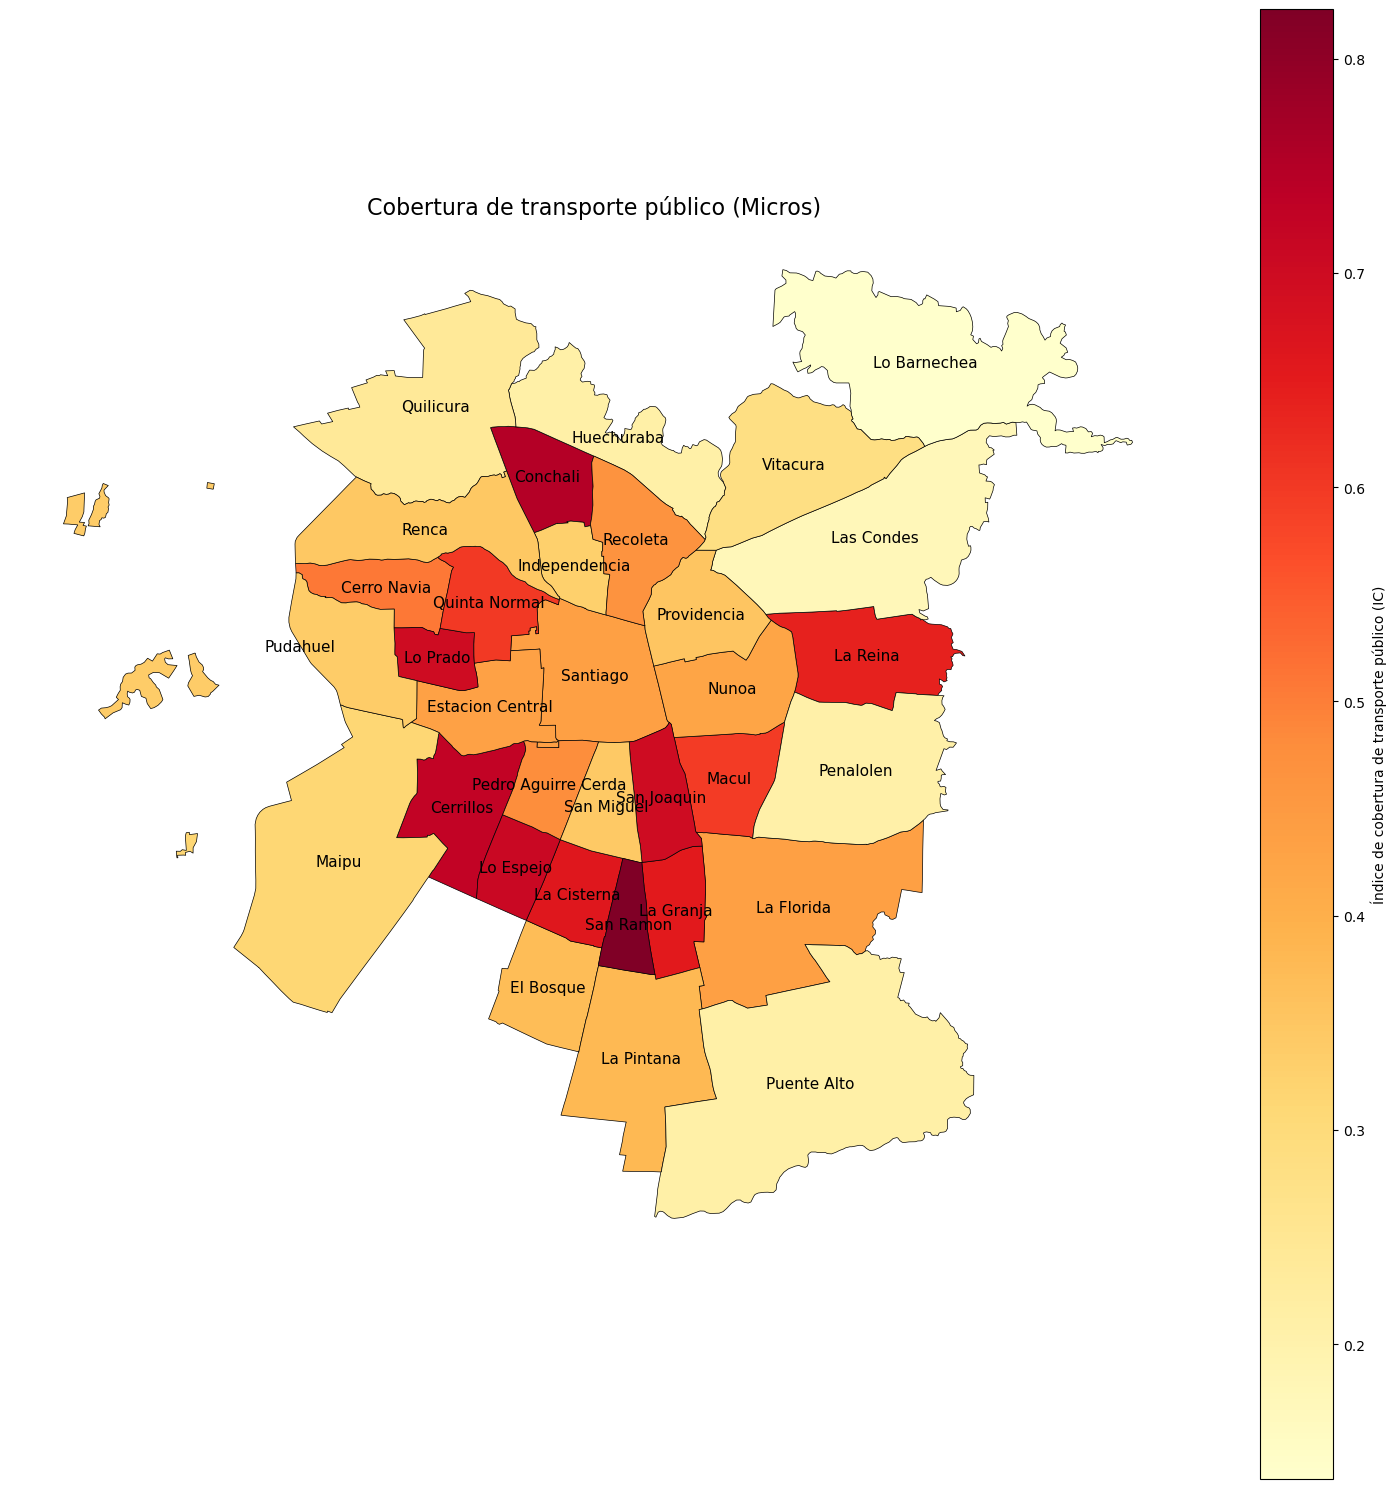

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

datos_comunas.plot(column='IC', ax=ax, legend=True,
                   legend_kwds={'label': 'Índice de cobertura de transporte público (IC)',
                                'orientation': 'vertical'},
                   cmap='YlOrRd',
                   edgecolor='black', linewidth=0.5)

for idx, row in datos_comunas.iterrows():
    if row['geometry'] is not None:  
        centroid = row['geometry'].centroid
        ax.annotate(
            text=row['nombre_comuna'], 
            xy=(centroid.x, centroid.y),
            ha='center', va='center', fontsize=11, color='black'
        )

plt.title('Cobertura de transporte público (Micros) ', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
if datos_comunas.crs != "EPSG:4326":
    datos_comunas = datos_comunas.to_crs("EPSG:4326")

In [25]:
from branca.colormap import LinearColormap

IC_min, IC_max = datos_comunas['IC'].min(), datos_comunas['IC'].max()
if IC_min >= IC_max:
    raise ValueError()

colormap = LinearColormap(
    colors=['yellow', 'orange', 'red'],
    vmin=IC_min,
    vmax=IC_max
)

m = folium.Map(location=[-33.4489, -70.6693], zoom_start=11)

for idx, row in datos_comunas.iterrows():
    if row['geometry'] is not None and row['geometry'].is_valid:  
        folium.GeoJson(
            data=row['geometry'].__geo_interface__,  
            style_function=lambda x, ic=row['IC']: {
                'fillColor': colormap(ic),  
                'color': 'black',  
                'weight': 1,
                'fillOpacity': 0.7  
            },
            tooltip=folium.Tooltip(
                f"""
                <b>Comuna:</b> {row['nombre_comuna']}<br>
                <b>Número de paradas:</b> {row['num_paradas']}<br>
                <b>Población proyectada 2024:</b> {row['Proyeccion_Personas_2024']:,.0f}<br>
                <b>Área urbanizada:</b> {row['area_urbanizada']:.2f} km²<br>
                <b>Paradas por cada 1000 habitantes:</b> {(row['IPH']*1000):.4f}<br>
                <b>Paradas por cada km2:</b> {row['IPA']:.4f}<br>
                <b>IC:</b> {row['IC']:.4f}
                """
            )
        ).add_to(m)

colormap.add_to(m)
colormap.caption = 'Índice de Cobertura (IC)'

m.save('mapa_dinamico_transporte_publico_urbanizado.html')
